In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))

learning_rate = 0.001
epochs = 5001
step_size = 1000
gamma = 0.1


L_x = 1000
N_s = 2001
L_p, x2, x3, h = torch.tensor(100.0), torch.tensor(-30.0), torch.tensor(-30.0), torch.tensor(25.0)
theta0, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
theta0 = theta0.detach().cpu().numpy()
# theta0 = np.zeros((1,N_s,2))
# theta0[0,:,0] = np.linspace(-L_x, 0, N_s)

1336001


In [3]:
print(theta0)

[[[ 0.0000000e+00  0.0000000e+00]
  [-6.8507820e-01  0.0000000e+00]
  [-1.3701564e+00  0.0000000e+00]
  ...
  [-9.9862988e+02  0.0000000e+00]
  [-9.9931494e+02  0.0000000e+00]
  [-1.0000000e+03  0.0000000e+00]]]


0 0.6711504682898521 loss =  9345647.0


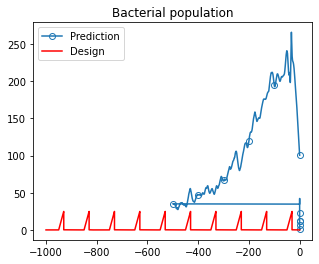

200 0.009752847254276276 loss =  9038367.0


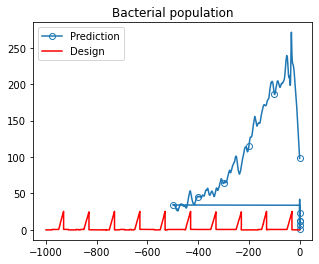

400 0.009866517037153244 loss =  8703250.0


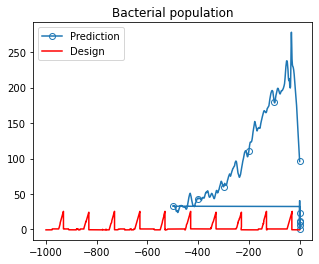

600 0.009729178622364998 loss =  8376806.5


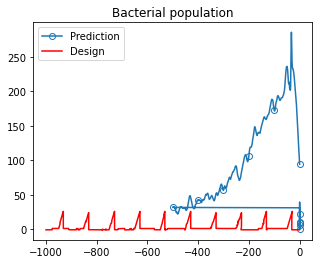

800 0.011827150359749794 loss =  8072112.5


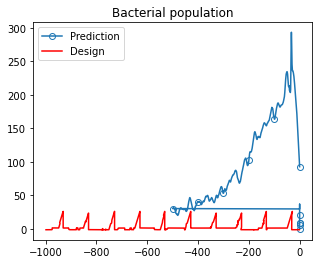

1000 0.009975496679544449 loss =  7784326.5


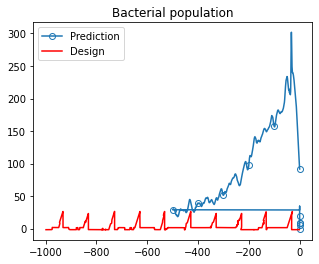

1200 0.009906778112053871 loss =  7756785.0


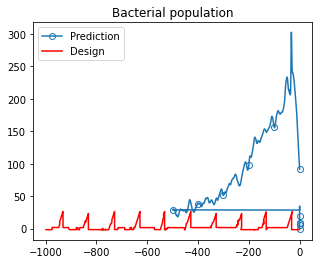

1400 0.009737066924571991 loss =  7729869.5


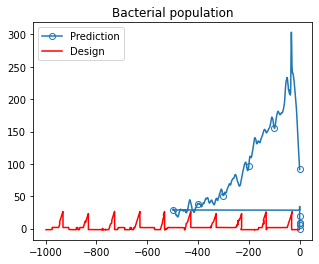

1600 0.009748179465532303 loss =  7703491.5


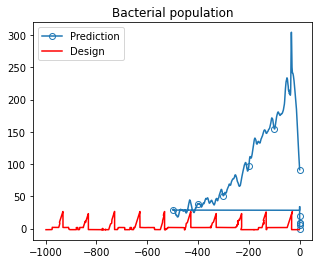

1800 0.009836092591285706 loss =  7677669.0


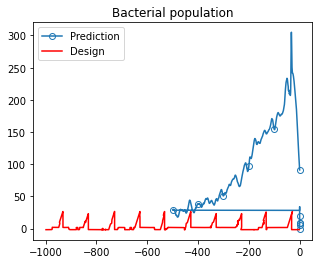

2000 0.009752573445439339 loss =  7652422.0


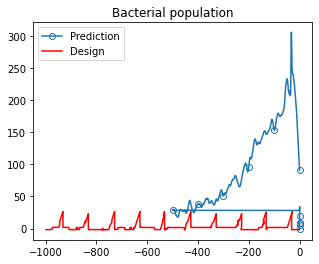

2200 0.009747443720698357 loss =  7650068.5


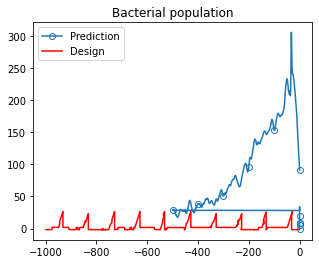

2400 0.00976685993373394 loss =  7647743.5


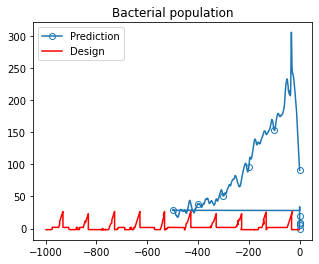

2600 0.009825335815548897 loss =  7645453.5


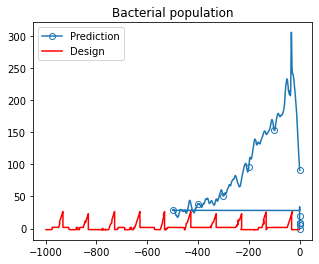

2800 0.009754423052072525 loss =  7643210.5


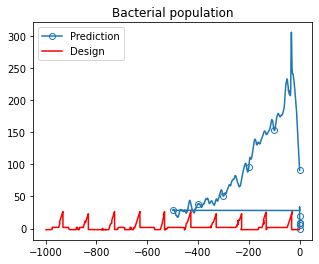

KeyboardInterrupt: 

In [4]:
theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True, device=device)

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 500
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
xx_mask[0:1000] = 0.0
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    out = torch.clip(model(theta).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = theta.detach().cpu().numpy()
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

In [26]:
theta0

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-6.8508e-01,  0.0000e+00],
         [-1.3702e+00,  0.0000e+00],
         ...,
         [-9.9863e+02,  0.0000e+00],
         [-9.9931e+02,  0.0000e+00],
         [-1.0000e+03,  0.0000e+00]]], device='cuda:0')